### Name : Shiva Nagendra Babu
### ID : 0903676

### TOPIC : AIRLINE SENTIMENTAL ANALYSIS  

### 1.IMPORTNG ALL THE IMPORTANT LIBRARIES  

In [104]:
%matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

In [106]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

### use the wordnet module from NLTK and download the tagsets data

In [107]:

from nltk.corpus import wordnet
nltk.download('tagsets')
nltk.help.upenn_tagset()


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [108]:
def get_wordnet_pos(word):
    tag = word[1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

### The SimpleTransformer class tokenizes, performs part-of-speech tagging, lemmatizes, and removes stopwords from sentences in a single line of code.

In [109]:
class SimpleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        self.stopwords = set(ENGLISH_STOP_WORDS)
        self.lemmatizer = WordNetLemmatizer()


    def transform(self, x, fit=False):
        matrix = []
        i = 0;
        for sentence in x:
            tokens = self.tokenizer.tokenize(sentence.lower())
            tokens_tags = nltk.pos_tag(tokens)   
            tokens = [self.lemmatizer.lemmatize(item[0], get_wordnet_pos(item)) for item in tokens_tags if item[1] not in ['MD','IN', 'FW', 'EX','PDT','POS', 'PRP$','PRP', 'UH', 'WDT', 'WRB','WP','WP$']]  
            tokens = [word for word in tokens if word not in self.stopwords and len(word) > 1]
            
            matrix.append(tokens)
            
            if i % 50 == 0:
                print(i)
            i = i + 1
                              
        return matrix

### Reading the tweets.csv Dataset

In [110]:
df = pd.read_csv('Tweets.csv')

In [111]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### selecting the airline sentiment text 

In [112]:
df = df[['airline_sentiment','text']]

In [113]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [114]:
df['airline_sentiment'] = df['airline_sentiment'].replace(['neutral','positive','negative'], [0,1,2])


In [115]:
df['airline_sentiment'].value_counts()

2    9178
0    3099
1    2363
Name: airline_sentiment, dtype: int64

In [116]:
target = df['airline_sentiment'].tolist()

In [117]:
text = df['text'].tolist()

### download some NLTK resources

In [118]:

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Tokenization

In [119]:
tokenzier = SimpleTransformer()
tokens = tokenzier.transform(text)
tokens[0]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

['virginamerica', 'dhepburn', 'say']

In [120]:
from nltk import FreqDist
fdist = FreqDist(np.concatenate(tokens)) 
for word, frequency in fdist.most_common(2000):
    print(u'{};{}'.format(word, frequency))

flight;4750
united;3567
usairways;2984
americanair;2899
southwestair;2461
jetblue;2393
http;1185
hour;1155
thanks;1054
service;1004
time;974
just;974
help;956
cancel;950
customer;942
delay;910
fly;773
bag;757
wait;747
plane;734
hold;719
make;690
need;675
amp;606
unite;598
thank;596
try;581
day;558
airline;554
gate;542
say;508
flightled;508
seat;506
virginamerica;505
tell;481
ve;480
don;469
bad;466
change;466
phone;460
book;460
know;437
today;432
check;430
late;426
agent;421
good;417
guy;415
work;407
ticket;399
miss;383
way;374
airport;370
leave;365
minute;348
great;341
want;335
travel;327
problem;314
weather;313
tomorrow;312
min;311
send;309
lose;308
sit;304
really;302
home;296
issue;295
people;289
look;288
hr;285
email;283
pay;281
board;281
use;278
dm;274
new;273
let;273
love;269
ll;265
luggage;265
number;260
crew;246
experience;237
trip;233
passenger;233
reservation;232
baggage;231
come;229
think;219
response;217
right;217
line;212
aa;212
long;205
didn;202
jfk;201
win;200
week;199
on

In [121]:
fdist.most_common(10_000)

[('flight', 4750),
 ('united', 3567),
 ('usairways', 2984),
 ('americanair', 2899),
 ('southwestair', 2461),
 ('jetblue', 2393),
 ('http', 1185),
 ('hour', 1155),
 ('thanks', 1054),
 ('service', 1004),
 ('time', 974),
 ('just', 974),
 ('help', 956),
 ('cancel', 950),
 ('customer', 942),
 ('delay', 910),
 ('fly', 773),
 ('bag', 757),
 ('wait', 747),
 ('plane', 734),
 ('hold', 719),
 ('make', 690),
 ('need', 675),
 ('amp', 606),
 ('unite', 598),
 ('thank', 596),
 ('try', 581),
 ('day', 558),
 ('airline', 554),
 ('gate', 542),
 ('say', 508),
 ('flightled', 508),
 ('seat', 506),
 ('virginamerica', 505),
 ('tell', 481),
 ('ve', 480),
 ('don', 469),
 ('bad', 466),
 ('change', 466),
 ('phone', 460),
 ('book', 460),
 ('know', 437),
 ('today', 432),
 ('check', 430),
 ('late', 426),
 ('agent', 421),
 ('good', 417),
 ('guy', 415),
 ('work', 407),
 ('ticket', 399),
 ('miss', 383),
 ('way', 374),
 ('airport', 370),
 ('leave', 365),
 ('minute', 348),
 ('great', 341),
 ('want', 335),
 ('travel', 327)

In [122]:
np.array(tokens).flatten()[0:2]

C:\Users\shiva\AppData\Local\Temp\ipykernel_6972\1753032188.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tokens).flatten()[0:2]


array([list(['virginamerica', 'dhepburn', 'say']),
       list(['virginamerica', 'plus', 've', 'added', 'commercial', 'experience', 'tacky'])],
      dtype=object)

### wordcloud

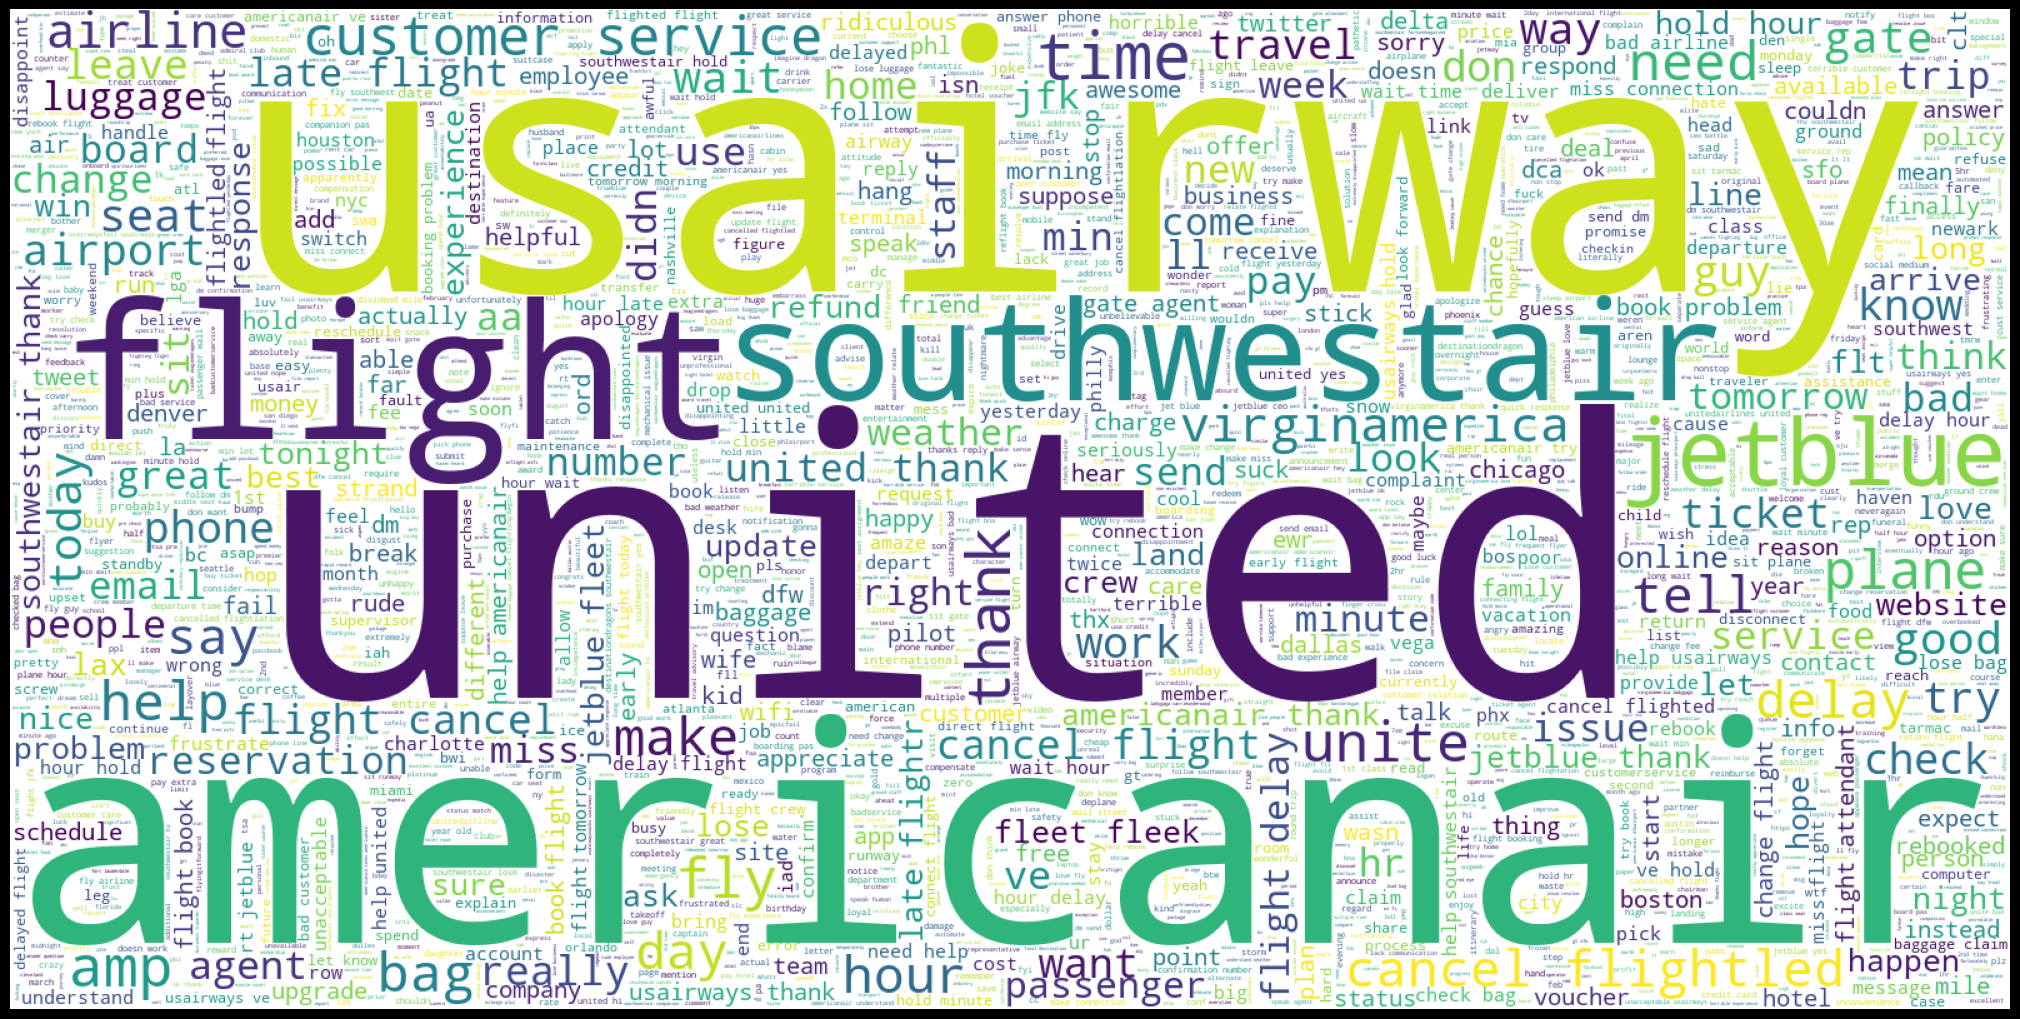

In [125]:
from wordcloud import WordCloud
# Join the different processed titles together.
flatten_list = [j for sub in tokens for j in sub]
long_string = ','.join(flatten_list)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white",width=1600, height=800, max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [126]:
np.array(tokens).flatten()[0:2]

C:\Users\shiva\AppData\Local\Temp\ipykernel_6972\1753032188.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tokens).flatten()[0:2]


array([list(['virginamerica', 'dhepburn', 'say']),
       list(['virginamerica', 'plus', 've', 'added', 'commercial', 'experience', 'tacky'])],
      dtype=object)

In [127]:
unique_words = set([j for sub in tokens for j in sub])
len(unique_words)

13006

### train

In [128]:
import sklearn 
X, test, y, y_test = sklearn.model_selection.train_test_split(tokens, target, test_size=.20)


In [129]:
pd.Series(y).value_counts()

2    7381
0    2444
1    1887
dtype: int64

### model building

def build_model():  
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_shape=(X2.shape[1],)))
    model.add(layers.Dropout(.4))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.4))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(.4))
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.metrics.Recall(), 'accuracy'])      
    return model
model = build_model()
model.summary()

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=.01, max_df=.99, max_features=10_000, lowercase=False)
X2 = vectorizer.fit_transform([" ".join(x) for x in X])
X2.shape
test2 = vectorizer.transform([" ".join(x) for x in test])

In [131]:
weights = dict([(i, r) for i, r in enumerate(sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y), y = y))])


### The code utilizes the KerasClassifier wrapper to train a Keras model using cross-validation and stores the trained model in the modelfit variable.

In [132]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#scikeras.wrappers
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = KerasClassifier(build_fn=build_model, epochs=300, batch_size=32, verbose=1, class_weight=weights)
#callbacks = [EarlyStopping(monitor='loss', patience=1,restore_best_weights=True)]
modelfit = model.fit(X2.toarray(), y)

Epoch 1/300


C:\Users\shiva\AppData\Local\Temp\ipykernel_6972\1732064220.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=300, batch_size=32, verbose=1, class_weight=weights)


366/366 [==============================] - 2s 2ms/step - loss: 0.9365 - recall_3: 0.3252 - accuracy: 0.5949
Epoch 2/300
366/366 [==============================] - 1s 2ms/step - loss: 0.8018 - recall_3: 0.5451 - accuracy: 0.6624
Epoch 3/300
366/366 [==============================] - 1s 2ms/step - loss: 0.7644 - recall_3: 0.5733 - accuracy: 0.6734
Epoch 4/300
366/366 [==============================] - 1s 2ms/step - loss: 0.7495 - recall_3: 0.5826 - accuracy: 0.6729
Epoch 5/300
366/366 [==============================] - 1s 2ms/step - loss: 0.7375 - recall_3: 0.5967 - accuracy: 0.6814
Epoch 6/300
366/366 [==============================] - 1s 2ms/step - loss: 0.7220 - recall_3: 0.6089 - accuracy: 0.6934
Epoch 7/300
366/366 [==============================] - 1s 2ms/step - loss: 0.7035 - recall_3: 0.6186 - accuracy: 0.6903
Epoch 8/300
366/366 [==============================] - 1s 2ms/step - loss: 0.6945 - recall_3: 0.6210 - accuracy: 0.6908
Epoch 9/300
366/366 [==============================]

366/366 [==============================] - 1s 2ms/step - loss: 0.3650 - recall_3: 0.8128 - accuracy: 0.8314
Epoch 69/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3675 - recall_3: 0.8161 - accuracy: 0.8316
Epoch 70/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3752 - recall_3: 0.8143 - accuracy: 0.8298
Epoch 71/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3634 - recall_3: 0.8130 - accuracy: 0.8331
Epoch 72/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3661 - recall_3: 0.8128 - accuracy: 0.8289
Epoch 73/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3504 - recall_3: 0.8216 - accuracy: 0.8375
Epoch 74/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3544 - recall_3: 0.8210 - accuracy: 0.8375
Epoch 75/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3625 - recall_3: 0.8178 - accuracy: 0.8325
Epoch 76/300
366/366 [=======================

366/366 [==============================] - 1s 2ms/step - loss: 0.3077 - recall_3: 0.8438 - accuracy: 0.8589
Epoch 136/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3069 - recall_3: 0.8490 - accuracy: 0.8600
Epoch 137/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3066 - recall_3: 0.8525 - accuracy: 0.8630
Epoch 138/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3064 - recall_3: 0.8499 - accuracy: 0.8597
Epoch 139/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3067 - recall_3: 0.8480 - accuracy: 0.8597
Epoch 140/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3021 - recall_3: 0.8500 - accuracy: 0.8601
Epoch 141/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3048 - recall_3: 0.8478 - accuracy: 0.8602
Epoch 142/300
366/366 [==============================] - 1s 2ms/step - loss: 0.3065 - recall_3: 0.8478 - accuracy: 0.8594
Epoch 143/300
366/366 [===============

366/366 [==============================] - 1s 2ms/step - loss: 0.2772 - recall_3: 0.8594 - accuracy: 0.8707
Epoch 203/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2763 - recall_3: 0.8652 - accuracy: 0.8750
Epoch 204/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2800 - recall_3: 0.8613 - accuracy: 0.8737
Epoch 205/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2806 - recall_3: 0.8636 - accuracy: 0.8747
Epoch 206/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2813 - recall_3: 0.8589 - accuracy: 0.8703
Epoch 207/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2800 - recall_3: 0.8612 - accuracy: 0.8727
Epoch 208/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2686 - recall_3: 0.8648 - accuracy: 0.8781
Epoch 209/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2856 - recall_3: 0.8572 - accuracy: 0.8683
Epoch 210/300
366/366 [===============

366/366 [==============================] - 1s 2ms/step - loss: 0.2695 - recall_3: 0.8696 - accuracy: 0.8789
Epoch 270/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2691 - recall_3: 0.8669 - accuracy: 0.8769
Epoch 271/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2641 - recall_3: 0.8722 - accuracy: 0.8804
Epoch 272/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2666 - recall_3: 0.8676 - accuracy: 0.8773
Epoch 273/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2631 - recall_3: 0.8720 - accuracy: 0.8823
Epoch 274/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2630 - recall_3: 0.8695 - accuracy: 0.8790
Epoch 275/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2638 - recall_3: 0.8703 - accuracy: 0.8798
Epoch 276/300
366/366 [==============================] - 1s 2ms/step - loss: 0.2652 - recall_3: 0.8699 - accuracy: 0.8792
Epoch 277/300
366/366 [===============

In [133]:
predictedp = model.predict_proba(test2.toarray())
predicted = model.predict(test2.toarray())

92/92 [==============================] - 0s 1ms/step


In [134]:

import scikitplot as skplt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [10, 10]

In [135]:
print(model.score(test2.toarray(), y_test))

92/92 [==============================] - 0s 2ms/step - loss: 3.6683 - recall_3: 0.6902 - accuracy: 0.6936
0.693647563457489


###  displaying two confusion matrices: one normalized and one without normalization, using the predicted labels (predicted) and the actual labels (y_test) using scikit-plot (skplt.metrics.plot_confusion_matrix) and matplotlib (plt.show()) libraries.

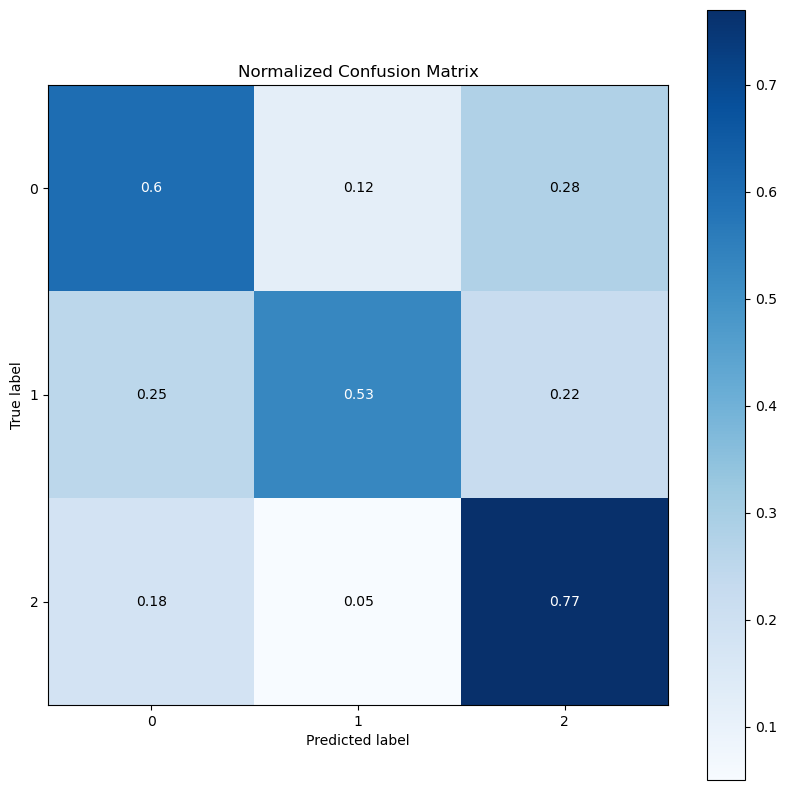

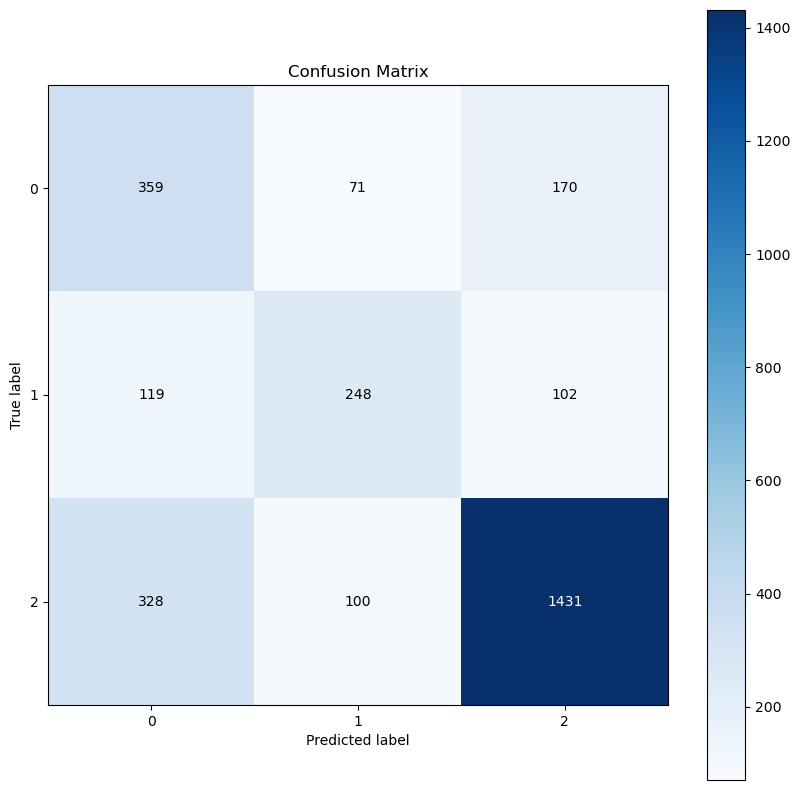

In [101]:
skplt.metrics.plot_confusion_matrix(y_test, predicted, normalize=True)
plt.show()
skplt.metrics.plot_confusion_matrix(y_test, predicted, normalize=False)
plt.show()

### displaying precision-recall curves and ROC curves using the predicted probabilities (predictedp) and the actual labels (y_test) with the help of scikit-plot (skplt.metrics.plot_precision_recall_curve and skplt.metrics.plot_roc) and matplotlib (plt.show()) libraries.

C:\Users\shiva\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


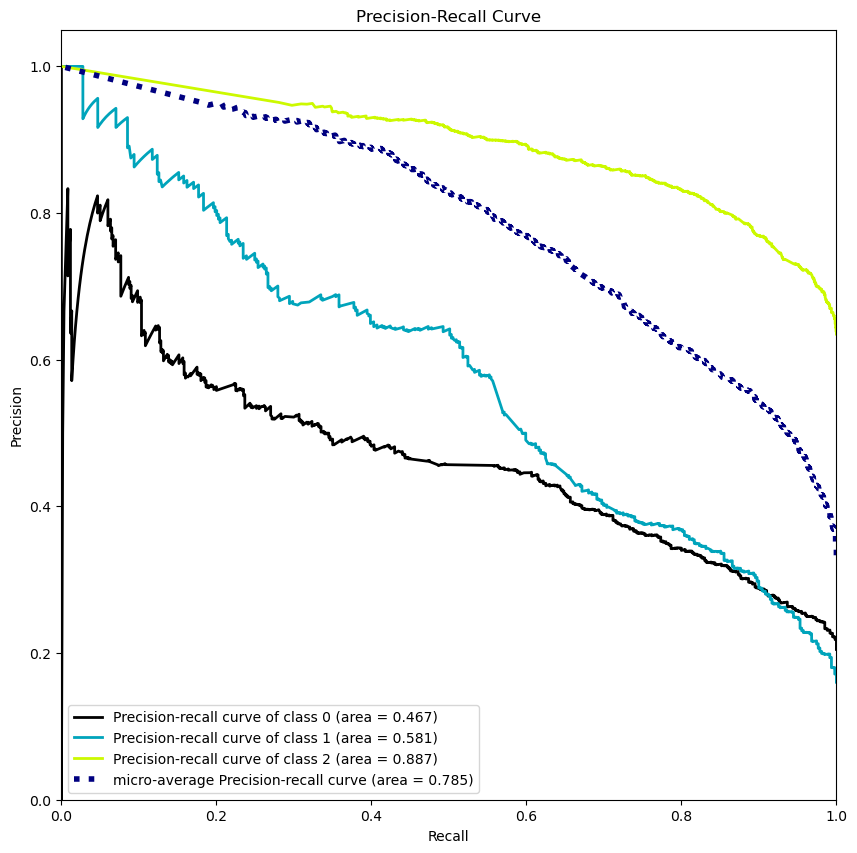

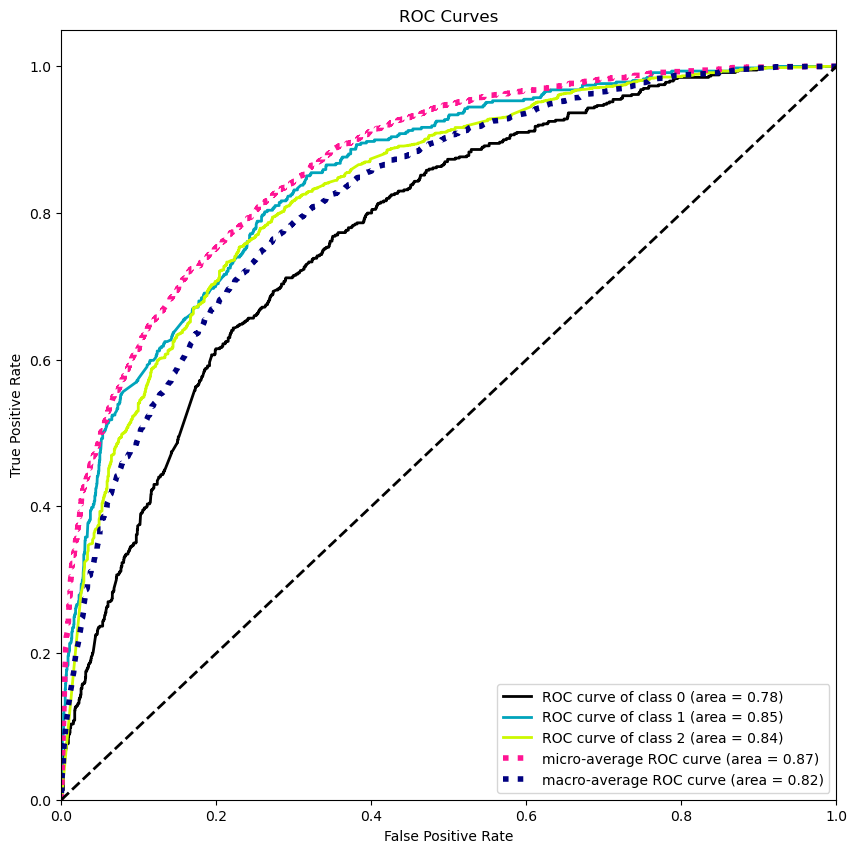

In [102]:
skplt.metrics.plot_precision_recall_curve(y_test, predictedp)
skplt.metrics.plot_roc(y_test,predictedp)
plt.show()

### final result Accuracy

In [103]:
print(accuracy_score(y_test, predicted))
print(precision_score(y_test, predicted, average='macro'))
print(recall_score(y_test, predicted,average='macro'))
print(f1_score(y_test, predicted,average='macro'))
#  accuracy, precision, recall, and F1 score for the predicted labels compared to the actual labels,
# providing evaluation metrics for the classification model's performance.

0.6960382513661202
0.6258589087856249
0.6322955581221942
0.6242361040670683


### The sentiment analysis of the "tweets.csv" dataset on airline tweets resulted in a 69% accuracy. The analysis revealed that customers expressed both positive and negative sentiments towards the airlines. Positive sentiment was associated with praise for good service and positive experiences, while negative sentiment reflected issues such as flight delays, poor customer service, and lost luggage. Some tweets had a neutral sentiment. The analysis provides valuable insights for airlines to improve customer satisfaction, address concerns, and maintain a positive brand image. Continuous monitoring of sentiment is crucial for staying responsive to customer feedback.